In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split

All questions in this section pertain to two of the datasets listed above in Exam Materials
(training_set_data.csv and unlabeled_data.csv), with the data_dictionary.txt file providing the
metadata needed to understand the contents and formats of each .csv. 

Please note that the data is still in its raw, original form and may require some cleaning and/or standardization.


Imagine we are being asked by one of our clients, ACME X, to predict if a given individual is
uninsured or not (health insurance). Using the data in training_set_data.csv, please train a model
to predict whether each person in the data set is uninsured or not. 


Furthermore, our main contact
at ACME X will need to explain the basics of the model to their smart, but non-technical
coworkers, so interpretability of how the model inputs relate to the predictions will be important.

In [18]:
train = pd.read_csv('training_set_data.csv')
pd.set_option('display.max_columns', 500)
train.head(3)

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,uninsured,household_id
0,1,45,citizen_birth,native_born,15,908.0,62.0,800.0,11.0,35.0,married,not_student,FEMALE,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
1,2,47,citizen_birth,native_born,50,180499.0,49.0,160007.0,20424.0,19.0,married,not_student,MALE,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
2,4,26,citizen_birth,native_born,0,7367.0,93.0,4.0,20.0,7250.0,never_married,not_student,male,over_five_years_ago,not_reported,English,0,0,1,0,0,0,0,0,2


In [29]:
train.school_status.value_counts()

not_student       53862
public_school      3914
private_school     1821
Name: school_status, dtype: int64

In [22]:
train.sex = train.sex.replace({'FEMALE': 'F'})
train.sex = train.sex.replace({'female': 'F'})

train.sex = train.sex.replace({'MALE': 'M'})
train.sex = train.sex.replace({'male': 'M'})

train.sex.value_counts()

F    30834
M    28763
Name: sex, dtype: int64

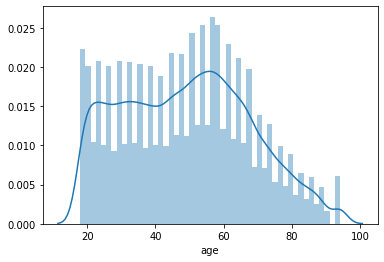

In [25]:
sns.distplot(train.age)

In [31]:
# unlabeled = pd.read_csv('unlabeled_data.csv')
# pd.set_option('display.max_columns', 500)
# unlabeled.head()

In [33]:
train.head()

,person_id,age,citizen_status,nativity_status,weekly_hours_worked,total_income,self_employed_income,wage_income,interest_income,other_income,marital_status,school_status,sex,when_last_worked,worked_last_week,language,race_native_american,race_asian,race_black,race_native_hawaiian,race_pacific_islander,race_white,race_other,uninsured,household_id
0,1,45,citizen_birth,native_born,15,908.0,62.0,800.0,11.0,35.0,married,not_student,F,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
1,2,47,citizen_birth,native_born,50,180499.0,49.0,160007.0,20424.0,19.0,married,not_student,M,in_last_year,worked,English,0,0,0,0,0,1,0,0,1
2,4,26,citizen_birth,native_born,0,7367.0,93.0,4.0,20.0,7250.0,never_married,not_student,M,over_five_years_ago,not_reported,English,0,0,1,0,0,0,0,0,2
3,5,42,citizen_naturalized,foreign_born,0,22970.0,51.0,46.0,283.0,22590.0,never_married,public_school,M,in_last_five_years,did_not_work,Korean,0,1,0,0,0,0,0,0,3
4,6,79,citizen_naturalized,foreign_born,0,7941.0,23.0,94.0,73.0,7751.0,married,not_student,M,over_five_years_ago,did_not_work,Korean,0,1,0,0,0,0,0,0,3
